In [1]:
import numpy as np
from sklearn import linear_model
from scipy.stats import zscore
from scipy.spatial.distance import squareform,pdist
import pickle
import matplotlib.pyplot as plt

In [55]:
N_RUNS = 10

def load_data(fn):
    with open('./results/' + fn,'rb') as f:    
        data = pickle.load(f)
    return data

def gen_modelrdms(monitor=0):
    '''
    generates model rdms
    returns design matrix (z-scored lower triangular of mod rdms) & mod rdms
    '''
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1)),np.zeros((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))
    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))
    # parallel model 
       
    a = a.flatten()
    b = b.flatten()
    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
    
    s,d = np.meshgrid(np.arange(1,6),np.arange(1,6))
    s = s.flatten()
    d = d.flatten()
    s_s = np.concatenate((s,s),axis=0)[:,np.newaxis]
    d_d = np.concatenate((d,d),axis=0)[:,np.newaxis]
    ctx = np.concatenate((np.concatenate((np.zeros((25,1)),np.ones((25,1))),axis=1),np.concatenate((np.ones((25,1)),np.zeros((25,1))),axis=1)),axis=0)

    ss_rdm = squareform(pdist(np.concatenate((s_s,ctx),axis=1)))
    dd_rdm = squareform(pdist(np.concatenate((d_d,ctx),axis=1)))
     
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(dd_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(ss_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((5,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm    
    rdms[3] = dd_rdm
    rdms[4] = ss_rdm
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm   
    return rdms,dmat,data_orig

def extract_condition_rdms(rdms):
    da_db = rdms[:,:50,:50]
    sa_sb = rdms[:,50:,50:]    

    da_sb1 = np.concatenate([rdms[:,:25,:25], rdms[:,:25,75:]], axis=2)
    da_sb2 = np.concatenate([rdms[:,75:,:25], rdms[:,75:,75:]], axis=2)
    da_sb = np.concatenate([da_sb1, da_sb2], axis=1)    

    db_sa = rdms[:,25:75, 25:75]

    da_sa1 = np.concatenate([rdms[:,:25,:25], rdms[:,:25,50:75]], axis=2)
    da_sa2 = np.concatenate([rdms[:,50:75,:25], rdms[:,50:75,50:75]], axis=2)
    da_sa = np.concatenate([da_sb1, da_sb2], axis=1)

    db_sb1 = np.concatenate([rdms[:,25:50,25:50], rdms[:,25:50,50:75]], axis=2)
    db_sb2 = np.concatenate([rdms[:,50:75,25:50], rdms[:,50:75,50:75]], axis=2)
    db_sb = np.concatenate([da_sb1, da_sb2], axis=1)
    
    cond_rdms=[da_db, sa_sb, da_sb, db_sa, da_sa, db_sb]
    
    return cond_rdms

def stats_fit_rdms(dmat,mlp_outputs):
    '''
    constructs rdm from hidden layer outputs 
    (at single run level)
    regresses lower triangular of these against the design 
    matrix of model rdms
    '''
    regr = linear_model.LinearRegression()
    coeffs = np.empty((N_RUNS,6,dmat.shape[1]))
    cond_rdms = extract_condition_rdms(mlp_outputs)
    for ii in range(N_RUNS):
        for jj in range(6):
            rdm=cond_rdms[jj]
            rdm=rdm[ii,:,:]
            y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
            regr.fit(dmat,y)
            coeffs[ii,jj,:] = np.asarray(regr.coef_)
    return coeffs
def compute_rdm_fits(file_names):
    '''
    wrapper that loops over simulation files 
    and performs rdm regression for each individual simulation
    '''
    _,dmat,_ = gen_modelrdms()
    modelfits = np.empty((len(file_names),N_RUNS,6,dmat.shape[1]))
    for ii,fn in enumerate(file_names):
        data = load_data(fn)
        modelfits[ii,:,:,:] = stats_fit_rdms(dmat,data[9]) #9 for 2nd layer, 8 for 1st layer
    return modelfits
def plot_modelfits(file_names,title_strings,model_labels = ['grid','orthogonal','parallel','size','dangerousness']):
    '''
    wrapper that loops over individual simulation files,
    regresses neural rdms against model rdms 
    and creates one figure with standardised betas per simulation 
    (mean + sem across individual runs)
    '''
    fits = compute_rdm_fits(file_names)
    subtitles = ['da_db', 'sa_sb', 'da_sb', 'db_sa', 'da_sa', 'db_sb']
    for ii in range(fits.shape[0]):
        plt.figure(figsize=(40,10))
        plt.suptitle(title_strings[ii])
        for jj in range(6):
            f_m = np.mean(fits[ii,:,jj,:],0)
            f_e = np.std(fits[ii,:,jj,:],0)/np.sqrt(N_RUNS)
            plt.subplot(1,6,jj+1)
            plt.bar(np.arange(len(f_m)),f_m,yerr=f_e)
            plt.xticks(ticks=np.arange(0,len(model_labels)),labels=model_labels,fontsize=20)
            plt.ylabel('parameter estimate (a.u.)',fontsize=14)
            plt.xlabel('Model RDM',fontsize=14)
            plt.title(subtitles[jj])

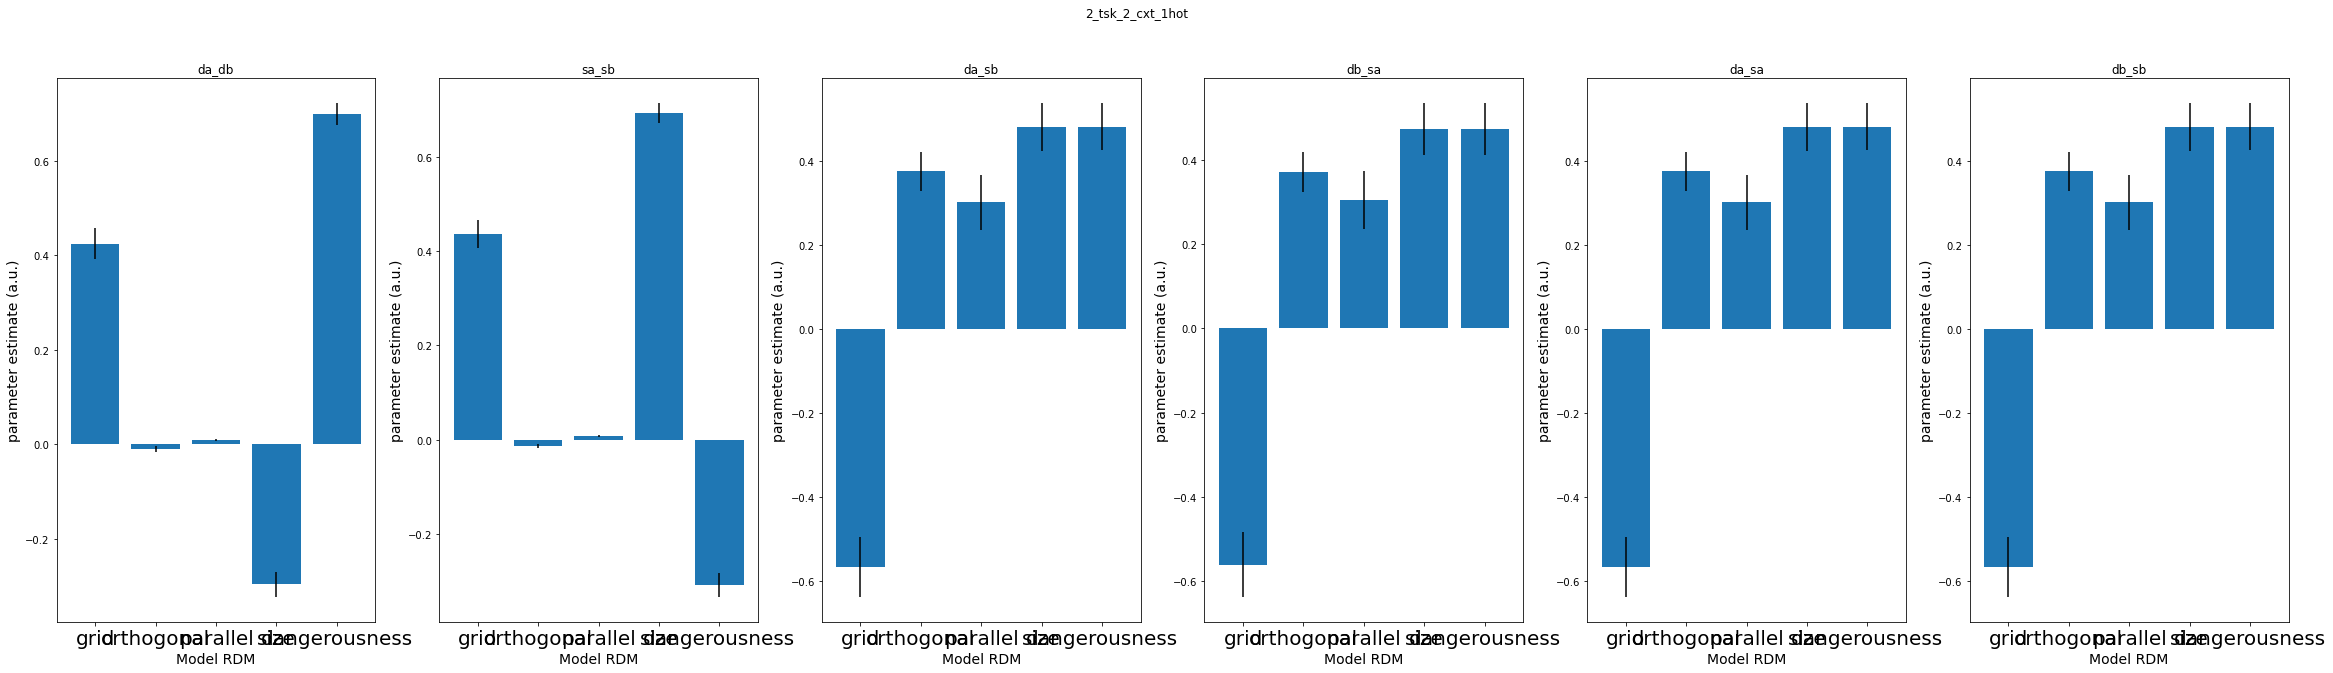

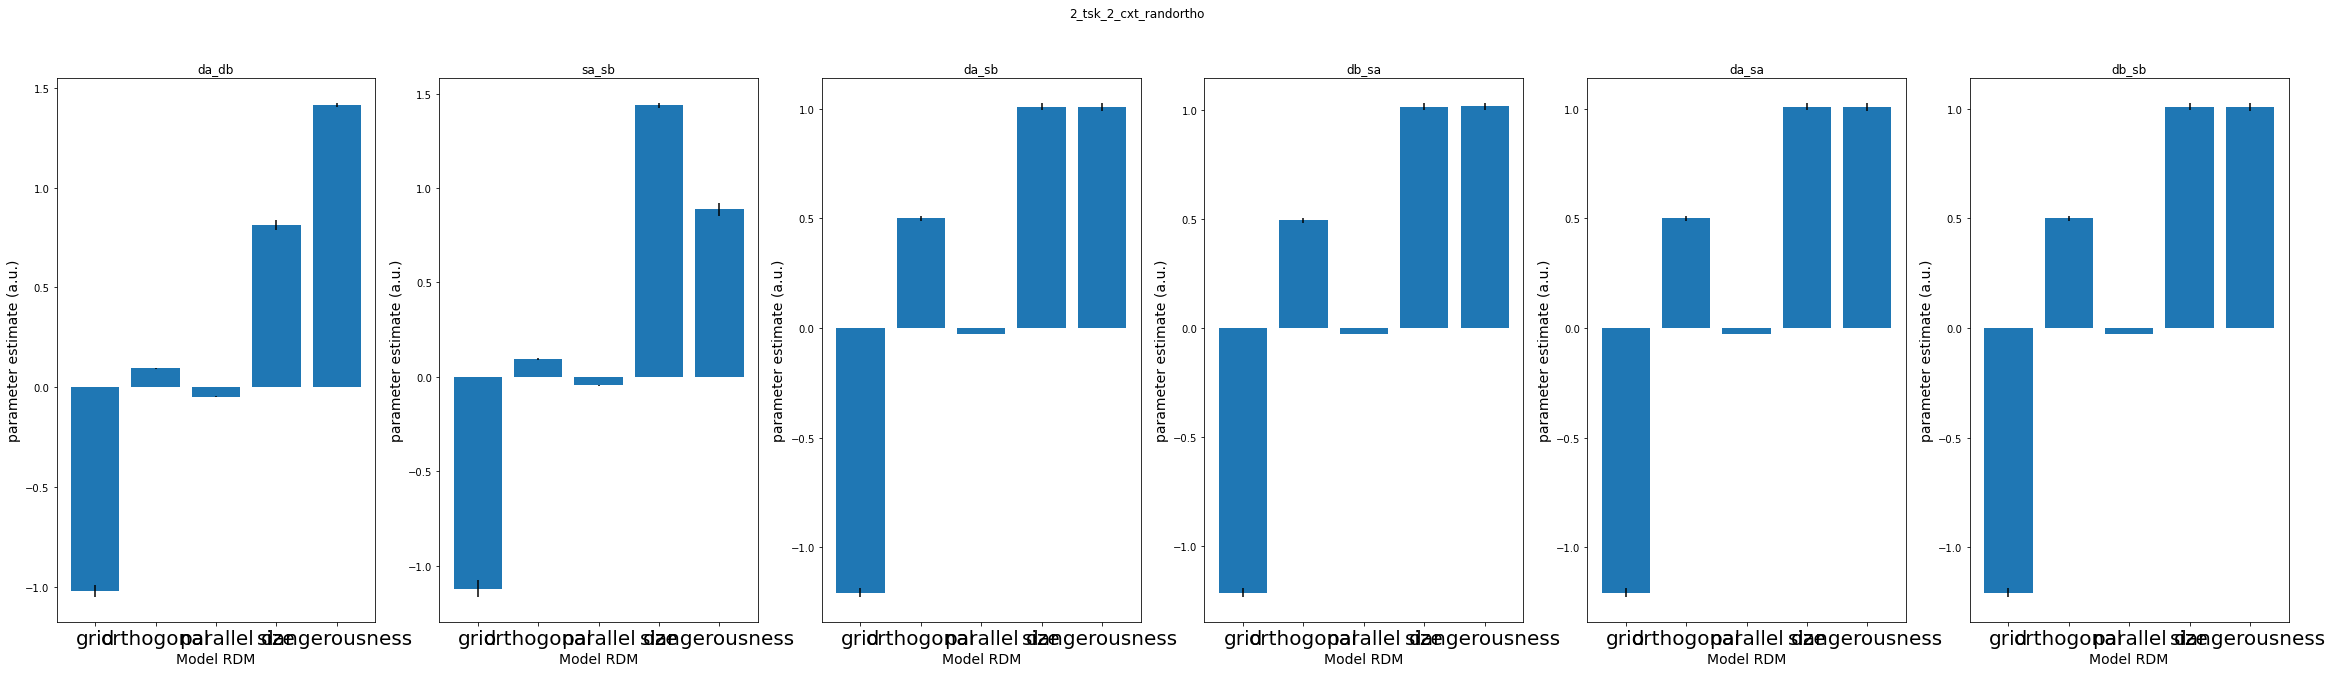

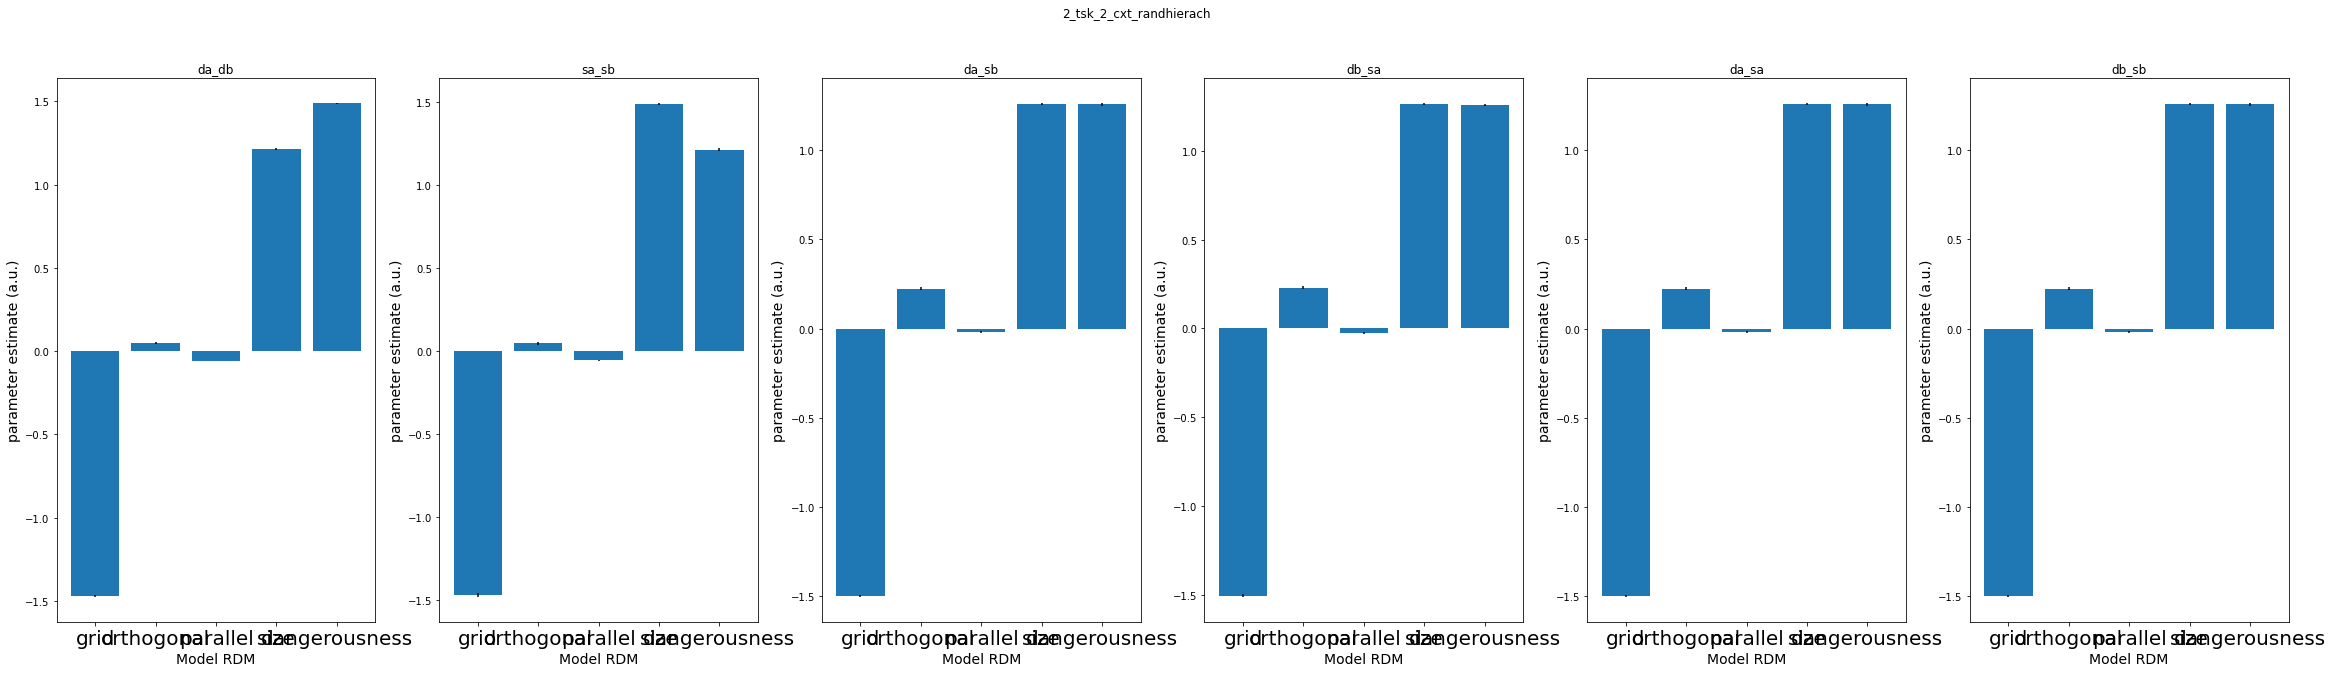

In [56]:
file_names = ['2tsk_2cxt_1hot', '2tsk_2cxt_randortho', '2tsk_2cxt_randhierach']
title_strings = ['2_tsk_2_cxt_1hot', '2_tsk_2_cxt_randortho', '2_tsk_2_cxt_randhierach']
plot_modelfits(file_names,title_strings)

In [49]:
data = load_data('2tsk_2cxt_randortho')


cond_rdms = extract_condition_rdms(data[9])
for jj in range(6):
    rdm=cond_rdms[jj]
    rdm=rdm[0,:,:]
    y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
    print(y.dtype)
    #print(np.isnan(y).any())

float64
float64
float64
float64
float64
float64
